### IMPORT SECTION

In [1]:
# Anıl Öztürk
# 504181504
#########################

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
import scipy.io

from PIL import Image
from pylab import *
from numpy import *
from scipy.cluster.vq import *

from numpy import linalg as LA
import scipy.stats as stats

### For eye-health 🤡

In [2]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

import warnings
warnings.filterwarnings("ignore")

### Matrix Readings

In [3]:
ex1_mat = scipy.io.loadmat('./Exercise_1_data/adjacencyMatrix.mat')["A"]
ex2_1_mat = scipy.io.loadmat('./Exercise_2_data/brainGraph1.mat')["W"]
ex2_2_mat = scipy.io.loadmat('./Exercise_2_data/brainGraph2.mat')["W"]

# Part 1: Bellman-Ford shortest path algorithm

### 1.1. Explain the key steps of Bellman-Ford algorithm (one-by-one)
**1. Initialization Phase:** Setting distances all of the nodes except source node as $\infty$. Setting distance of the source node as $0$. Setting predecessors of all nodes as $NaN$.

**2. Do relaxation for each edge, $N$ times**: We do the relaxation for each edge $(u,v)$ with weight $w$ as; if distance of $v$ is greater than (distance of $u$) + $w$, we should set distance of $v$ as that value. And we also set the predecessor of $v$ as $u$. This way, we also store the shortest path route information besides its value.

**3. We got the shortest path values and routes**

#### Relaxation Definition
We do that for correcting the distances. If we found shorter path than the current one for a node-pair, we should set that as the new shortest path (distance) value. We do the comparison for each edge. Then, when we moved into another node; we repeat the relaxation again. Because we may find even shorter paths.



### 1.2. Write a function called BellmanFordAlgo that takes (i) A and (2) a starting node ID as inputs, and outputs an array as in Graph Theory Blink 5.4 a , where each row represents a node in the graph G and comprising three columns (nodes, shortest distance from source input node, previous node).

In [4]:
def BellmanFordAlgo(A, node_id, printfunc = False):
    
    node_count = A.shape[0]
    distance = [np.inf] * node_count # setting inf-like
    distance[node_id] = 0 # zeroing the source distance
    prev_nodes = [None] * node_count
    
    edges = []
    edge_locs = np.argwhere(A!=0) # getting non-zero weight locations [destination, source]
    
    for loc in edge_locs:
        edges.append([loc[0], loc[1], A[loc[0],loc[1]]]) # [source, destination, weight]
    
    for node in range(node_count): # updating N times
        for edge in edges: # for every edge
            if (distance[edge[1]] > distance[edge[0]] + edge[2]) :
                distance[edge[1]] = distance[edge[0]] + edge[2] # updating distance
                prev_nodes[edge[1]] = edge[0] # updating "previous node" parameter

    return_matrix = np.zeros((node_count, 3)) # creating return matrix format
    
    for i in range(return_matrix.shape[0]): # filling return matrix
        return_matrix[i,0] = i # node id
        return_matrix[i,1] = distance[i] # shortest distance from the source
        return_matrix[i,2] = prev_nodes[i] # previous node parameter
    
    if printfunc:
        printed_matrix = pd.DataFrame(return_matrix, columns=['Node ID', 'Shortest Path from the Source (Node ' + str(node_id) + ')', 'Previous Node ID'])
        print(printed_matrix)
        print("\nReturning in the array format...\n")
        
    return return_matrix

### 1.3. Run your function in the Jupyter Notebook on the input adjacency matrix A (see Fig. fig:1) and display the output array. You can find the data inside ‘Exercise 1 data’ folder.

Since the output will include $inf$ for unaccessable nodes and $NaN$ for their previous nodes, I didn't convert them to integers. Because $inf$ and $NaN$ types use float-based definitions.

In [5]:
source_node = 2

print(BellmanFordAlgo(ex1_mat, source_node, printfunc=True))

   Node ID  Shortest Path from the Source (Node 2)  Previous Node ID
0      0.0                                     inf               NaN
1      1.0                                     1.0               5.0
2      2.0                                     0.0               NaN
3      3.0                                     5.0               1.0
4      4.0                                     8.0               3.0
5      5.0                                     3.0               2.0

Returning in the array format...

[[ 0. inf nan]
 [ 1.  1.  5.]
 [ 2.  0. nan]
 [ 3.  5.  1.]
 [ 4.  8.  3.]
 [ 5.  3.  2.]]


# 2. Global efficiency, diffusion efficiency and graph morphospace
### 2.1. Write a function globalEfficiency, which inputs a graph adjacency matrix A and outputs the global efficiency value.

In [6]:
def globalEfficiency(Adj, thresh=0.1):
    
    
    A = Adj.copy()
    
    
    under_treshs = A<thresh
    
    node_count = len(A)
    
    A[under_treshs] *= 0. # threshold masking
    
    spaths = np.array([])
    
    for node in tqdm(range(node_count)):
        
        bfout = BellmanFordAlgo(A, node)
        bfout = np.delete(bfout, node, 0) # deleting self-pairs
        
            
        spaths = np.concatenate((spaths, bfout[:,1]), axis=None)
        
    spaths = 1 / spaths # distance to global efficiency
    spaths = np.nan_to_num(spaths) # getting rid of NaNs
    g_eff = np.sum(spaths) / (node_count * (node_count-1))
    
    return g_eff

### 2.2. Write a function diffusionEfficiency, which inputs a graph adjacency matrix A and outputs the diffusion efficiency value.

In [7]:
def createU(Adj):
    
    A = Adj.copy()
    node_count = A.shape[0]
    
    # creating stength matrix
    out_degrees = np.sum(A, axis=1).reshape(-1,1)
    in_degrees = np.sum(A, axis=0).reshape(-1,1)
    
    strength = out_degrees
    
    strength_matrix = np.eye(node_count) * strength
    
    # computing U matrix
    inverse_strength = np.linalg.inv(strength_matrix)
    u_matrix = np.matmul(A, inverse_strength)
    
    return u_matrix

In [8]:
def diffusionEfficiency(Adj, thresh=0.5):
    
    A = Adj.copy()
    
    N = A.shape[0]
    I = np.eye(N) # identity matrix

    under_treshs = A<thresh
    A[under_treshs] *= 0. # threshold masking
    
    U = createU(A) # creating U matrix

    Xsh_s = []
    
    for h in tqdm(range(N)): # target nodes
                
        Uh = U.copy()
        Uh[h,:] *= 0 
        in_paranthesis = I - Uh
        
        try:
            inverse_term = np.linalg.inv(in_paranthesis)
        
            for s in range(N): # source nodes
                if s==h: # i!=j
                    continue

                #print(in_paranthesis)
                temp_sum_sh = 0
                temp_sum_sh = inverse_term[:,s].sum()

                Xsh_s.append(temp_sum_sh)
        
        except:
            for s in range(N):
                Xsh_s.append(np.inf)

    
    Xsh_s = np.array(Xsh_s)

    Xsh_s = 1 / Xsh_s # distance to global efficiency
    
    Xsh_s = np.nan_to_num(Xsh_s) # getting rid of NaNs
    d_eff = np.sum(Xsh_s) / (N * (N-1))
    
    return d_eff

### 2.3. Create a scatter plot where x-axis represents threshold value α ∈ [0 : 0.1 : 0.9] (0.1 denotes the threshold step size) and the y-axis represents the global efficiency E glob of brain graph adjacency matrices ‘Exercise 2 data/ brainGraph1.mat’ and ‘Exercise 2 data/ brainGraph2.mat’ (Fig. fig:2). By thresholding each adjacency matrix at different threshold values α ∈ [0 : 0.1 : 0.9], examine how its global and diffusion efficiencies change. Use two different colors to compare the change in global efficiency across both brain graphs.
### &
### 2.4. In a second figure, plot the diffusion efficiency E_diff of both matrices against α.

In [9]:
threshs = np.arange(0.,1,0.1)

brain1_geffs = []
brain2_geffs = []

print("Calculating global efficiencies for Brain Graph 1...")
print("-"*55)
time.sleep(1.5)
for thresh in threshs:
    print("Calculating for threshold:", np.round(thresh,1))
    time.sleep(1)
    g_eff = globalEfficiency(ex2_1_mat, thresh=thresh)
    brain1_geffs.append(g_eff)

print("-"*55)
print("\nCalculating global efficiencies for Brain Graph 2...")
print("-"*55)
time.sleep(1.5)
for thresh in threshs:
    print("Calculating for threshold:", np.round(thresh,1))
    time.sleep(1)
    g_eff = globalEfficiency(ex2_2_mat, thresh=thresh)
    brain2_geffs.append(g_eff)

Calculating global efficiencies for Brain Graph 1...
-------------------------------------------------------
Calculating for threshold: 0.0


100%|██████████| 116/116 [00:12<00:00,  9.17it/s]


Calculating for threshold: 0.1


100%|██████████| 116/116 [00:08<00:00, 13.44it/s]


Calculating for threshold: 0.2


100%|██████████| 116/116 [00:05<00:00, 19.45it/s]


Calculating for threshold: 0.3


100%|██████████| 116/116 [00:03<00:00, 32.20it/s]


Calculating for threshold: 0.4


100%|██████████| 116/116 [00:02<00:00, 54.18it/s]


Calculating for threshold: 0.5


100%|██████████| 116/116 [00:01<00:00, 94.76it/s]


Calculating for threshold: 0.6


100%|██████████| 116/116 [00:00<00:00, 149.83it/s]


Calculating for threshold: 0.7


100%|██████████| 116/116 [00:00<00:00, 222.13it/s]


Calculating for threshold: 0.8


100%|██████████| 116/116 [00:00<00:00, 367.20it/s]


Calculating for threshold: 0.9


100%|██████████| 116/116 [00:00<00:00, 406.75it/s]


-------------------------------------------------------

Calculating global efficiencies for Brain Graph 2...
-------------------------------------------------------
Calculating for threshold: 0.0


100%|██████████| 116/116 [00:12<00:00,  9.37it/s]


Calculating for threshold: 0.1


100%|██████████| 116/116 [00:08<00:00, 13.47it/s]


Calculating for threshold: 0.2


100%|██████████| 116/116 [00:05<00:00, 20.60it/s]


Calculating for threshold: 0.3


100%|██████████| 116/116 [00:03<00:00, 32.44it/s]


Calculating for threshold: 0.4


100%|██████████| 116/116 [00:02<00:00, 55.23it/s]


Calculating for threshold: 0.5


100%|██████████| 116/116 [00:01<00:00, 91.31it/s]


Calculating for threshold: 0.6


100%|██████████| 116/116 [00:00<00:00, 120.67it/s]


Calculating for threshold: 0.7


100%|██████████| 116/116 [00:00<00:00, 198.01it/s]


Calculating for threshold: 0.8


100%|██████████| 116/116 [00:00<00:00, 299.85it/s]


Calculating for threshold: 0.9


100%|██████████| 116/116 [00:00<00:00, 389.69it/s]


In [10]:
threshs = np.arange(0.,1,0.1)

brain1_deffs = []
brain2_deffs = []

print("Calculating diffusion efficiencies for Brain Graph 1...")
print("-"*55)
time.sleep(1.5)
for thresh in threshs:
    print("Calculating for threshold:", np.round(thresh,1))
    time.sleep(1)
    g_eff = diffusionEfficiency(ex2_1_mat, thresh=thresh)
    brain1_deffs.append(g_eff)

print("-"*55)
print("\nCalculating diffusion efficiencies for Brain Graph 2...")
print("-"*55)
time.sleep(1.5)
for thresh in threshs:
    print("Calculating for threshold:", np.round(thresh,1))
    time.sleep(1)
    g_eff = diffusionEfficiency(ex2_2_mat, thresh=thresh)
    brain2_deffs.append(g_eff)

Calculating diffusion efficiencies for Brain Graph 1...
-------------------------------------------------------
Calculating for threshold: 0.0


100%|██████████| 116/116 [00:00<00:00, 632.38it/s]


Calculating for threshold: 0.1


100%|██████████| 116/116 [00:00<00:00, 747.32it/s]


Calculating for threshold: 0.2


100%|██████████| 116/116 [00:00<00:00, 778.59it/s]


Calculating for threshold: 0.3


100%|██████████| 116/116 [00:00<00:00, 765.67it/s]


Calculating for threshold: 0.4


100%|██████████| 116/116 [00:00<00:00, 1893.58it/s]


Calculating for threshold: 0.5


100%|██████████| 116/116 [00:00<00:00, 2081.83it/s]


Calculating for threshold: 0.6


100%|██████████| 116/116 [00:00<00:00, 2000.80it/s]


Calculating for threshold: 0.7


100%|██████████| 116/116 [00:00<00:00, 1805.69it/s]


Calculating for threshold: 0.8


100%|██████████| 116/116 [00:00<00:00, 2049.37it/s]


Calculating for threshold: 0.9


100%|██████████| 116/116 [00:00<00:00, 1898.12it/s]


-------------------------------------------------------

Calculating diffusion efficiencies for Brain Graph 2...
-------------------------------------------------------
Calculating for threshold: 0.0


100%|██████████| 116/116 [00:00<00:00, 824.65it/s]


Calculating for threshold: 0.1


100%|██████████| 116/116 [00:00<00:00, 838.53it/s]


Calculating for threshold: 0.2


100%|██████████| 116/116 [00:00<00:00, 301.40it/s]


Calculating for threshold: 0.3


100%|██████████| 116/116 [00:00<00:00, 294.68it/s]


Calculating for threshold: 0.4


100%|██████████| 116/116 [00:00<00:00, 590.13it/s]


Calculating for threshold: 0.5


100%|██████████| 116/116 [00:00<00:00, 2130.02it/s]


Calculating for threshold: 0.6


100%|██████████| 116/116 [00:00<00:00, 1779.84it/s]


Calculating for threshold: 0.7


100%|██████████| 116/116 [00:00<00:00, 1807.04it/s]


Calculating for threshold: 0.8


100%|██████████| 116/116 [00:00<00:00, 1812.07it/s]


Calculating for threshold: 0.9


100%|██████████| 116/116 [00:00<00:00, 1829.61it/s]


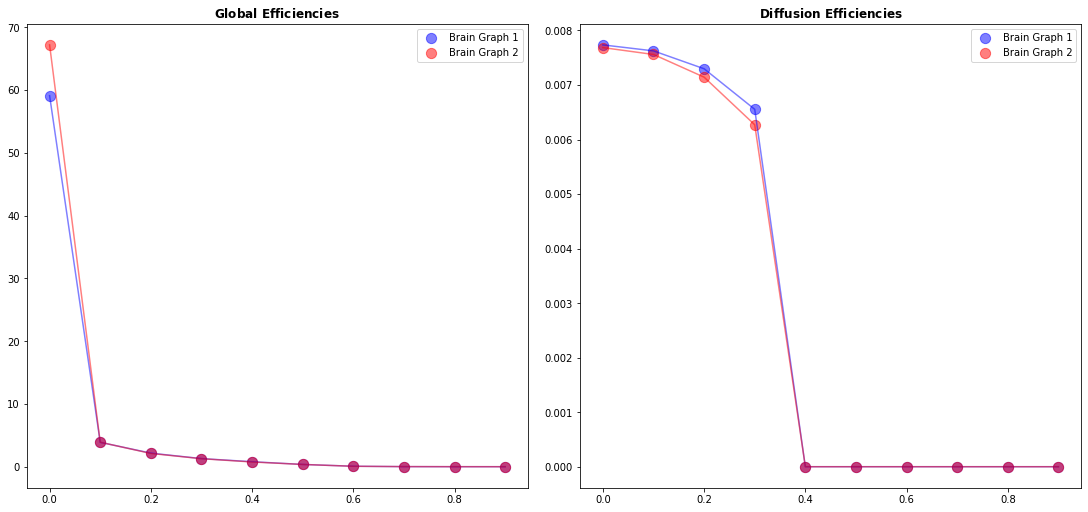

In [11]:
fig, axs = plt.subplots(1,2, figsize=(15, 7), constrained_layout=True)
axs[0].title.set_text(r"$\mathbf{Global\ Efficiencies}$")
axs[1].title.set_text(r"$\mathbf{Diffusion\ Efficiencies}$")

## Global efficiency plot
axs[0].scatter(threshs, brain1_geffs, s=105, color="blue", alpha=0.5, label="Brain Graph 1")
axs[0].scatter(threshs, brain2_geffs, s=105, color="red", alpha=0.5, label="Brain Graph 2")

axs[0].plot(threshs, brain1_geffs, color="blue", alpha=0.5)
axs[0].plot(threshs, brain2_geffs, color="red", alpha=0.5)

axs[0].legend()

## Diffusion efficiency plot
axs[1].scatter(threshs, brain1_deffs, s=105, color="blue", alpha=0.5, label="Brain Graph 1")
axs[1].scatter(threshs, brain2_deffs, s=105, color="red", alpha=0.5, label="Brain Graph 2")
axs[1].legend()

axs[1].plot(threshs, brain1_deffs, color="blue", alpha=0.5)
axs[1].plot(threshs, brain2_deffs, color="red", alpha=0.5)

plt.show()

This way, we see value inconsistency issues while plotting. I see the not-properly distributed weight values as the main reason of this. Still, we can observe the effect of thresholding by looking at the slope and the change of values.

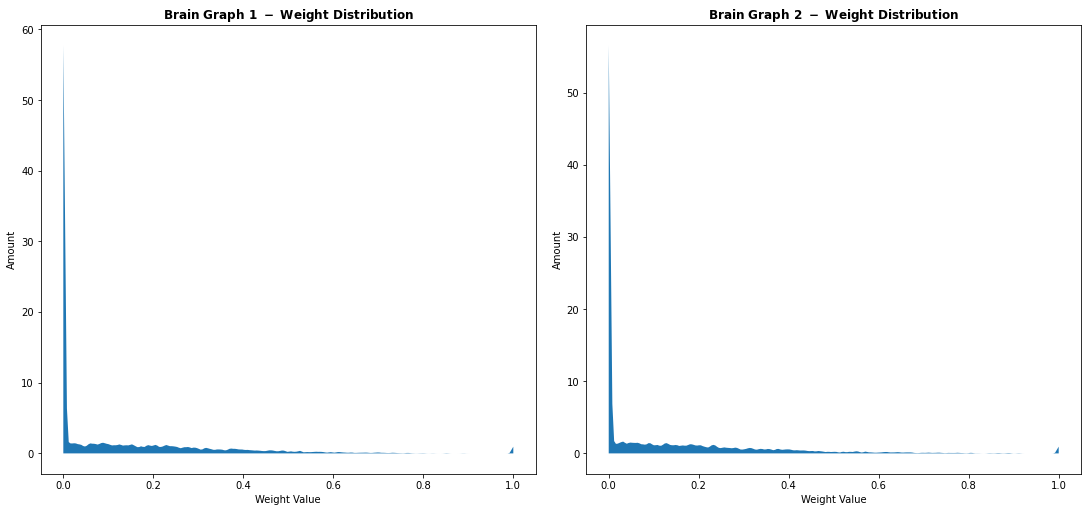

Brain Graph 1 - Min Non-Zero Value: 1.3320413669272628e-05
Brain Graph 1 - Max Value: 1.0
Brain Graph 1 - Mean Value: 0.11506288948673057

Brain Graph 2 - Min Non-Zero Value: 3.797616673278135e-05
Brain Graph 2 - Max Value: 1.0
Brain Graph 2 - Mean Value: 0.11413259509904974


In [12]:
ex2_1_flatten = stats.kde.gaussian_kde(ex2_1_mat.flatten(), bw_method=0.02)
ex2_2_flatten = stats.kde.gaussian_kde(ex2_2_mat.flatten(), bw_method=0.02)
x = np.linspace(0, 1, 250)

fig, axs = plt.subplots(1,2, figsize=(15, 7), constrained_layout=True)

axs[0].fill_between(x, ex2_1_flatten(x))
axs[1].fill_between(x, ex2_2_flatten(x))

axs[0].title.set_text(r"$\mathbf{Brain\ Graph\ 1\ -\ Weight\ Distribution}$")
axs[1].title.set_text(r"$\mathbf{Brain\ Graph\ 2\ -\ Weight\ Distribution}$")

axs[0].set_xlabel("Weight Value")
axs[0].set_ylabel("Amount")

axs[1].set_xlabel("Weight Value")
axs[1].set_ylabel("Amount")
plt.show()

print("Brain Graph 1 - Min Non-Zero Value:", ex2_1_mat[ex2_1_mat!=0].min())
print("Brain Graph 1 - Max Value:", ex2_1_mat[ex2_1_mat!=0].max())
print("Brain Graph 1 - Mean Value:", ex2_1_mat.mean())
print()
print("Brain Graph 2 - Min Non-Zero Value:", ex2_2_mat[ex2_2_mat!=0].min())
print("Brain Graph 2 - Max Value:", ex2_2_mat[ex2_2_mat!=0].max())
print("Brain Graph 2 - Mean Value:", ex2_2_mat.mean())

With this information, we can say that the extreme low values such as $e^{-5}$ have very large effect on efficiency scores. Normally, the efficiency values should be between $[0-1]$. But, the adjacency matrices have such values as $e^{-5}$.

The global efficiency values are being affected by them because of the $\frac{1}{distance}$ term. 

The diffusion efficiency values are also being affected by them, because the magnitude of the $\frac{w}{s}$ ratios in the $U$ matrix formula are being too small for the $e^{-5}$ terms.

---------------
##### And I also think we should use weight-distance $\frac{1}{distance}$ remapping for the global or diffusion efficiency. Because shortest path works on distance values, while diffusion efficiency works on affinity values. And these values don't represent each other.

### 2.5. What conclusions can you derive from previous plots? Compare diffusion and global efficiencies within a single graph and across both graphs.

We already interpreted the inconsistent values in both graphs. We can continue to interpret the plots in the functional manner.

#### Global Efficiency Graph
Both brain graphs use the edges with the smallest weight in choosing the shortest path. We can verify this by the sudden excessive drop in efficiency value after the thresholding is set to $0.1$. They decrease, because the brain graphs were using these $e^{-5}$ terms to choose the shortest path. Now they have to choose paths with more hop counts and greater weights. So the path lengths went almost $e^5$ times bigger. We see that Brain Graph $2$ has more global efficiency, which means it has shorter paths than Brain Graph $1$ overall.

#### Diffusion Efficiency Graph
The higher the threshold, the more edges pruned. We see that the efficiency of a random walker in arriving to the target has decreased significantly. From the weight distribution graphs, we can recall that both brain graphs contain almost no weighted edges that have larger weights than the $0.4-0.5$ range. Therefore, from the moment the threshold value is $0.4$, we see that random walkers have never been successful in reaching the target. The amount of road to the goal is getting so small, maybe now we need global information to reach the goal. We see that Brain Graph $1$ and Brain Graph $2$ have similar amount of diffusion efficiencies at each threshold steps. It means that they have alike structures and weight distributions.

#### Responses of Global Efficiency and Diffusion Efficiency to Thresholding
We see that both diffusion and global efficiencies decrease as we increase the weight threshold value. We reach at their minimum at around $0.4$ threshold value. We can say that the edges that have weights $\leq0.4$ have important roles in the graph. When they disappear, the graph disconnects or loses its efficiency in shortest path manner.

### 2.6. Plot a morphospace for the set of thresholded brain graphs at α ∈ [0 : 0.1 : 0.9], where the x-axis denotes E_diff and y-axis denotes E_glob . Use two different colors to compare the two thresholded graph sets derived from each brain graph, respectively.

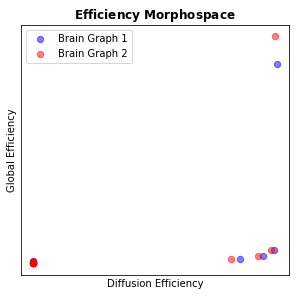

In [13]:
fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)

ax.title.set_text(r"$\mathbf{Efficiency\ Morphospace}$")

ax.scatter(brain1_deffs, brain1_geffs, s=40, color="blue", alpha=0.5, label="Brain Graph 1")
ax.scatter(brain2_deffs, brain2_geffs, s=40, color="red", alpha=0.5, label="Brain Graph 2")

ax.legend()
plt.xticks([], [])
plt.yticks([], [])

ax.set_xlabel("Diffusion Efficiency")
ax.set_ylabel("Global Efficiency")

plt.show()

### 2.7. Discuss the information flow efficiency for both brain graphs based on your morphospace plot

We see that there is a positive relationship between diffusion and global efficiencies. It counts for both brain graphs. We see exponential-like polynomial relationship between these efficiency values. If diffusion efficiency increases, global efficiency will increase exponentially with respect to the diffusion efficiency. At the end, we see the maximum diffusion efficiency with also maximum global efficiency. It means that the graph is well suited for both random walks and planned traversals. We also see that most of the values have been accumulated around $0$. Because after $0.4$ threshold value, the diffusion efficiencies have become zero.

# 3. Graph self-diffusion for image segmentation
### 3.1. Write a function called selfDiffuse that takes (i) a weighted graph adjacency matrix (i.e., similarity matrix) W and outputs the diffused matrix W ? (check algorithm fig:3.). Make sure that your algorithm automatically sets the optimal number of diffusion iterations t* as explained in the paper.

In [14]:
def calculate_optimal_iteration_count(W, P):
    
    n = W.shape[0]
    C = 0.05
  
    dof = np.trace(P)
    I = np.eye(n)
    
    lambdas, _ = LA.eig(P)
    lambda2 = np.sort(lambdas)[::-1][1]

    epsilon = 1e-10
    
    norm = LA.norm(W-np.matmul(W,P)-I)
    
    tstar = np.log(epsilon/((n-dof)*norm)) / np.log(lambda2-C)
    
    return np.ceil(tstar).astype(int)
    
def selfDiffuse(mat):
    W = mat.copy()
    n = W.shape[0]
    I = np.eye(n)
    
    out_degrees = np.sum(W, axis=1).reshape(-1,1)
    D = np.eye(n) * out_degrees    
    D_inv = np.linalg.inv(D)
    P = np.matmul(D_inv, W)  
    
    tstar = calculate_optimal_iteration_count(W, P)
    print("t* =", tstar)
    
    t_values = np.linspace(1, 2*tstar, 5).astype(int)
    t_values[2] = tstar
    
    print("Self-diffusing the affinity matrix...")
    time.sleep(1)
    
    return_affinities = []
    
    for t in tqdm(range(t_values[-1])):
        
        W = np.matmul(W,P) + I
        
        if (t+1) in t_values:
            final_W = np.matmul(W, D_inv)
            return_affinities.append(final_W.copy())
    
    return return_affinities, t_values

### 3.2. Run selfDiffuse on both brain graph adjacency matrices ‘Exercise 2 data/ brainGraph1.mat’ and ‘Exercise 2 data/ brainGraph2.mat’. For each brain graph, visualize both original and diffused matrices.

t* = 87
Self-diffusing the affinity matrix...


100%|██████████| 174/174 [00:00<00:00, 11865.07it/s]


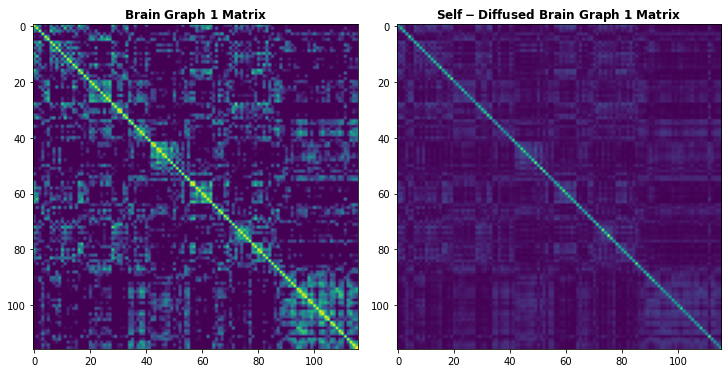

In [15]:
ex2_1_mat_diffused = selfDiffuse(ex2_1_mat.copy())[0][0]

fig, axs = plt.subplots(1,2, figsize=(10, 5), constrained_layout=True)

axs[0].title.set_text(r"$\mathbf{Brain\ Graph\ 1\ Matrix}$")
axs[0].imshow(ex2_1_mat)

axs[1].title.set_text(r"$\mathbf{Self-Diffused\ Brain\ Graph\ 1\ Matrix}$")
axs[1].imshow(ex2_1_mat_diffused)

plt.show()

t* = 91
Self-diffusing the affinity matrix...


100%|██████████| 182/182 [00:00<00:00, 7813.58it/s]


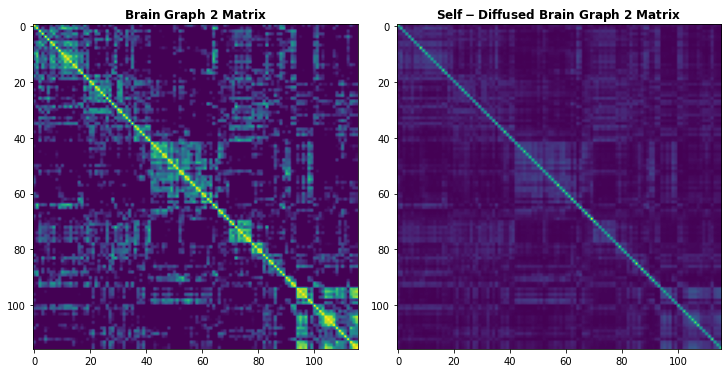

In [16]:
ex2_2_mat_diffused = selfDiffuse(ex2_2_mat.copy())[0][0]

fig, axs = plt.subplots(1,2, figsize=(10, 5), constrained_layout=True)

axs[0].title.set_text(r"$\mathbf{Brain\ Graph\ 2\ Matrix}$")
axs[0].imshow(ex2_2_mat)

axs[1].title.set_text(r"$\mathbf{Self-Diffused\ Brain\ Graph\ 2\ Matrix}$")
axs[1].imshow(ex2_2_mat_diffused)

plt.show()

### 3.3. Given the 2 images taken from the Berkeley Segmentation Data Set, generate the segmentation maps of each image using the Normalized Cut Python code https://github.com/marktao99/python/blob/master/CVP/samples/ncut.py. Display each original image and its corresponding output segmentation map.

I have reduced size of the images to solve RAM allocation Problem. The default code was also running very slowly due to the for-loop implementation. I have converted it to a vectorized numpy operation using following link:

https://stackoverflow.com/questions/6784281/affinity-matrix-calculation-using-numpy

Some sources say that the cluster operation should run on symmetrical affinity matrixes. But after the diffusion operation, the affinity matrixes are becoming asymmetrical. And this is unreasonable, because the similarity between x and y should be equal to the similarity between y and x. The diffusion adds virtual directional dimension into account. I have forced the diffused affinity matrices to be symmetrical by using maximum operator between they and their transposes.

In [17]:
def ncut_graph_matrix(img):
    """ Create matrix for normalized cut. The parameters are 
        the weights for pixel distance and pixel similarity. """
    
    im = img.copy().astype(np.float32)
    
    sigma_d=3e3
    sigma_g=1e-3
    
    m,n = im.shape[:2] 
    N = m*n
    
    # normalize and create feature vector of RGB or grayscale
    if len(im.shape)==3:
        for i in range(3):
            im[:,:,i] = im[:,:,i] / im[:,:,i].max()
        vim = im.reshape((-1,3))
    else:
        im = im / im.max()
        vim = im.flatten()
    
    # x,y coordinates for distance computation
    xx,yy = meshgrid(range(n),range(m))
    x,y = xx.flatten(),yy.flatten()
    
    # create matrix with edge weights
    W = zeros((N,N), 'f')
         
    dx = np.subtract.outer(x, x)
    dy = np.subtract.outer(y, y)
    d = dx**2 + dy**2
    
    if len(im.shape)==3:
        dvimr = np.subtract.outer(vim[:,0], vim[:,0])**2
        dvimg = np.subtract.outer(vim[:,1], vim[:,1])**2
        dvimb = np.subtract.outer(vim[:,2], vim[:,2])**2

        dvim = dvimr + dvimg + dvimb
    else:
        dvim = np.subtract.outer(vim, vim)**2

    W = exp(-d / sigma_d - 1.0 * dvim / sigma_g)
    
    return W

In [18]:
def cluster(Sim,k,ndim):
    """ Spectral clustering from a similarity matrix."""
    
    S = Sim.copy()
    
    # check for symmetry
    if sum(abs(S-S.T)) > 1e-10:
        S = np.maximum(S, S.T)
    
    # create Laplacian matrix
    rowsum = np.sum(np.abs(S),axis=0)
    D = np.diag(1 / np.sqrt(rowsum + 1e-6))
    L = np.matmul(D,np.matmul(S,D))

    # compute eigenvectors of L
    U,sigma,V = linalg.svd(L, full_matrices=False)
    
    # create feature vector from ndim first eigenvectors
    # by stacking eigenvectors as columns
    features = array(V[:ndim]).T

    # k-means
    features = whiten(features)
    centroids,distortion = kmeans(features,k, iter=1000)
    code,distance = vq(features,centroids)
        
    return code,V

### 3.4. For each image, change the Normalized Cut Python by applying self-diffuse to the similarity matrix W, then use W ? to perform the normalized cut and output the image segmentation map. For each image, display 5 different normalized cut segmentation maps when varying the diffusion threshold from t = 1 to t = 2 × t ?

In [19]:
ex3_1_img = Image.open("./Exercise_3_data/image1.jpg")
ex3_2_img = Image.open("./Exercise_3_data/image2.jpg")

divider = 10

newsize = (int(ex3_1_img.size[0]/divider), int(ex3_1_img.size[1]/divider))
ex3_1_img_resized = np.array(ex3_1_img.resize(newsize))

newsize2 = (int(ex3_2_img.size[0]/divider), int(ex3_2_img.size[1]/divider))
ex3_2_img_resized = np.array(ex3_2_img.resize(newsize2))

##### For first image

In [20]:
im1_similarity_matrix = ncut_graph_matrix(ex3_1_img_resized.copy())
im1_affinities_afterdiffuse,  im1_tvals_afterdiffuse = selfDiffuse(im1_similarity_matrix)

t* = 661
Self-diffusing the affinity matrix...


100%|██████████| 1322/1322 [01:18<00:00, 16.81it/s]


Performing clustering on affinity maps...


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


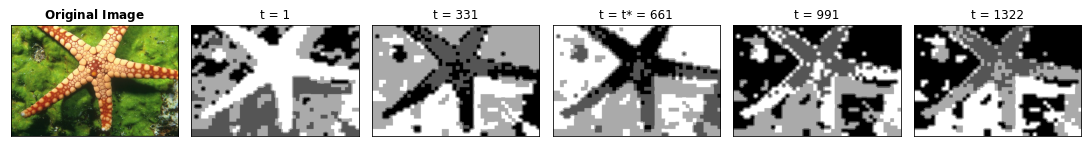

In [21]:
fig, axs = plt.subplots(1,6, figsize=(15, 7), constrained_layout=True)

axs[0].title.set_text(r"$\mathbf{Original\ Image}$")
axs[0].imshow(ex3_1_img)

print("Performing clustering on affinity maps...")
time.sleep(1)

for i in tqdm(range(len(im1_affinities_afterdiffuse))):
    titl = "t = "
    if i==2:
        titl = "t = t* = "
    code,V = cluster(im1_affinities_afterdiffuse[i],4, 35)
    code = code.reshape(newsize[1], newsize[0])
    code = Image.fromarray(np.uint8(code))
    code = code.resize((ex3_1_img.size[0], ex3_1_img.size[1]))
    axs[i+1].imshow(code, cmap="gray")
    axs[i+1].title.set_text(titl + str(im1_tvals_afterdiffuse[i]))


time.sleep(1)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])


plt.show()

##### For second image

In [22]:
im2_similarity_matrix = ncut_graph_matrix(ex3_2_img_resized.copy())
im2_affinities_afterdiffuse,  im2_tvals_afterdiffuse = selfDiffuse(im2_similarity_matrix)

t* = 662
Self-diffusing the affinity matrix...


100%|██████████| 1324/1324 [02:20<00:00,  9.40it/s]


Performing clustering on affinity maps...


100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


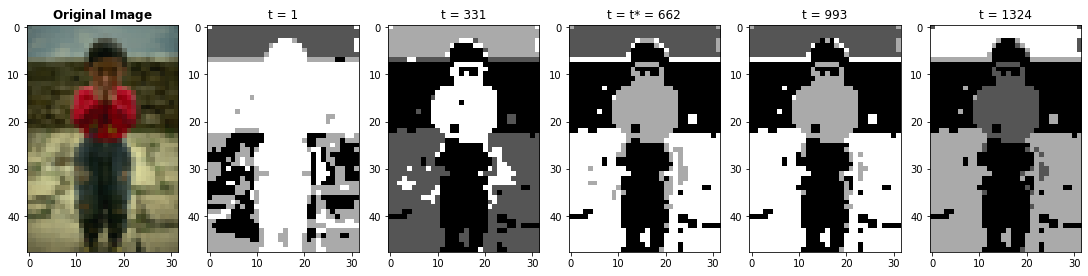

In [24]:
fig, axs = plt.subplots(1,6, figsize=(15, 7), constrained_layout=True)

axs[0].title.set_text(r"$\mathbf{Original\ Image}$")
axs[0].imshow(ex3_2_img_resized)

print("Performing clustering on affinity maps...")
time.sleep(1)

for i in tqdm(range(len(im2_affinities_afterdiffuse))):
    titl = "t = "
    if i==2:
        titl = "t = t* = "
    code,V = cluster(im2_affinities_afterdiffuse[i],4, 35)
    code = code.reshape(newsize2[1], newsize2[0])
    axs[i+1].imshow(code, cmap="gray")
    axs[i+1].title.set_text(titl + str(im2_tvals_afterdiffuse[i]))


time.sleep(1)

plt.show()